In [17]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Load dataset from the provided GitHub URL
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'
data = pd.read_csv(url)

# View the first few rows of the dataset
data.head()


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


In [19]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Check for duplicate rows
duplicate_values = data.duplicated().sum()

# Display the missing values and duplicate count
print(f"Missing values per column:\n{missing_values}")
print(f"Duplicate rows: {duplicate_values}")

Missing values per column:
Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
dtype: int64
Duplicate rows: 0


In [21]:
# Generate basic descriptive statistics for each feature
desc_stats = data.describe()

# Calculate additional statistics like median and range beyond the 95th percentile
median_values = data.median()
percentile_95 = data.quantile(0.95)
range_values = data.max() - data.min()

print(f"Descriptive Statistics:\n{desc_stats}")
print(f"Median values:\n{median_values}")
print(f"95th Percentile values:\n{percentile_95}")
print(f"Range values:\n{range_values}")


Descriptive Statistics:
         Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25%      593.000000          2.518815       4.916886          1.600466   
50%      746.000000          3.162035       6.201720          2.166883   
75%      934.000000          4.055272       7.744973          2.848840   
max     2239.000000          7.265566      21.138326          7.478505   

       lub oil temp  Coolant temp  
count  19535.000000  19535.000000  
mean      77.643420     78.427433  
std        3.110984      6.206749  
min       71.321974     61.673325  
25%       75.725990     73.895421  
50%       76.817350     78.346662  
75%       78.071691     82.915411  
max       89.580796  

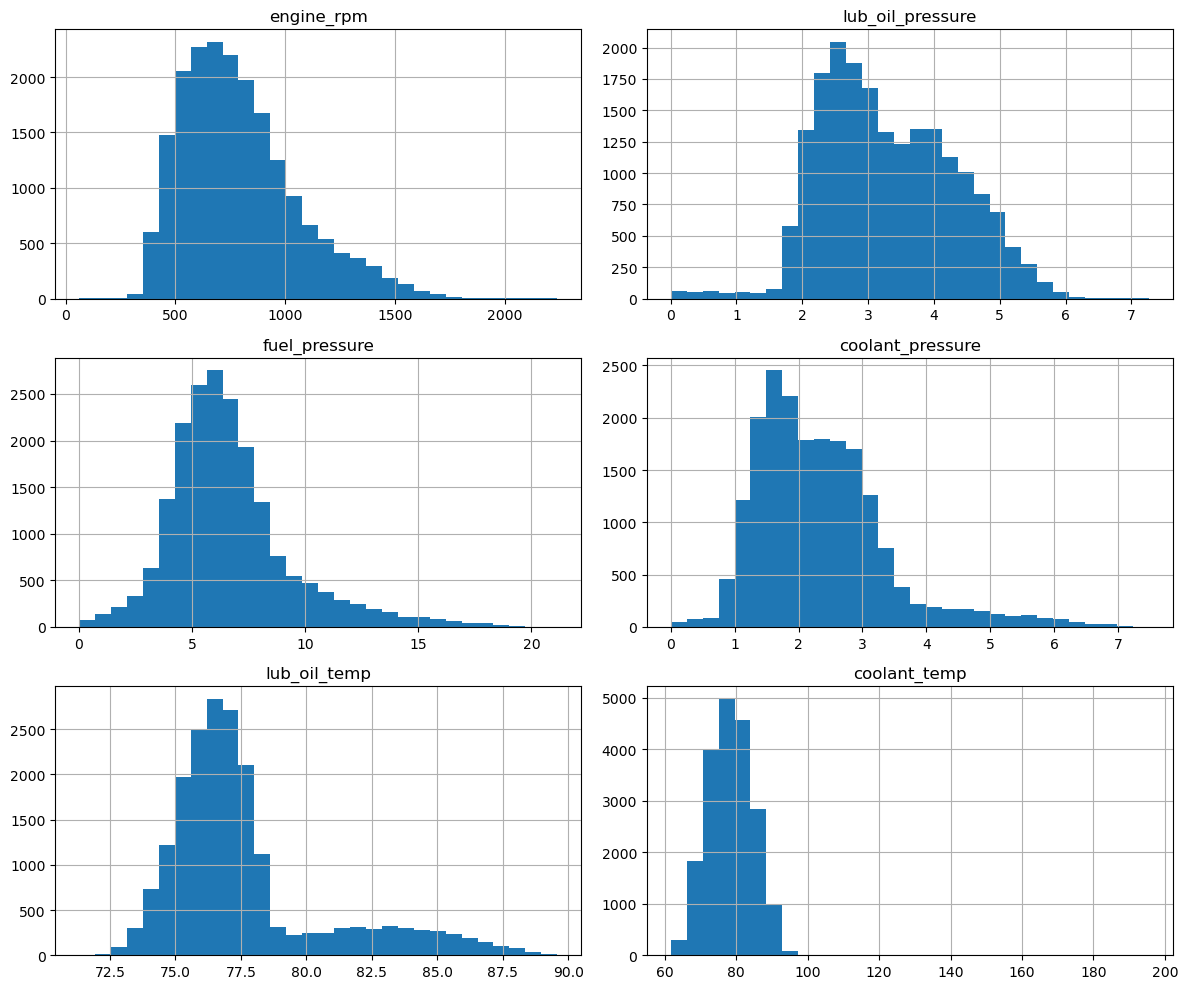

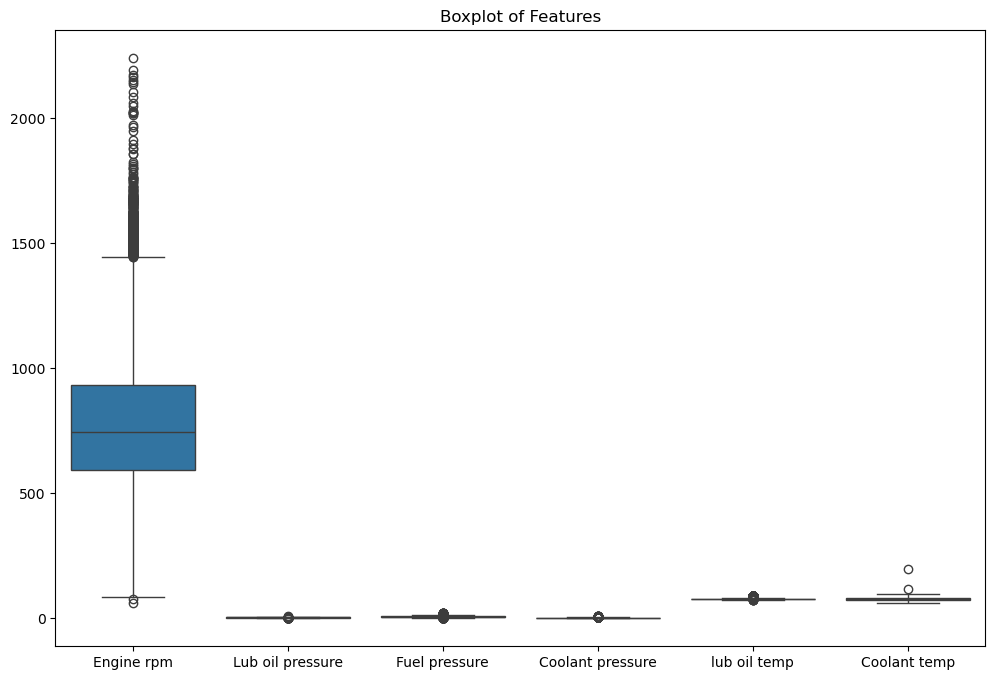

In [23]:
# Visualise Distribution and Extreme Values
# Histograms for all features
df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# Boxplot to check for extreme values (outliers)
plt.figure(figsize=(12, 8))
sns.boxplot(data=data)
plt.title('Boxplot of Features')
plt.show()



In [25]:
# Anomaly Detection Using Statistical Method (IQR)

def calculate_iqr_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)

# Create outlier columns
for col in df.columns:
    df[f'{col}_outlier'] = calculate_iqr_outliers(col)

# Identify rows where 2 or more features are outliers
outlier_cols = [col for col in df.columns if '_outlier' in col]
df['IQR_anomaly'] = (df[outlier_cols].sum(axis=1) >= 2).astype(int)

# Number of anomalies
print("Total IQR anomalies:", df['IQR_anomaly'].sum())


Total IQR anomalies: 422


In [39]:
# Anomaly Detection Using ML Models

#Feature Scaling for ML Algorithms
# Prepare features for ML (exclude outlier flags)
features = df[df.columns[:6]]  # assuming first six are the original features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

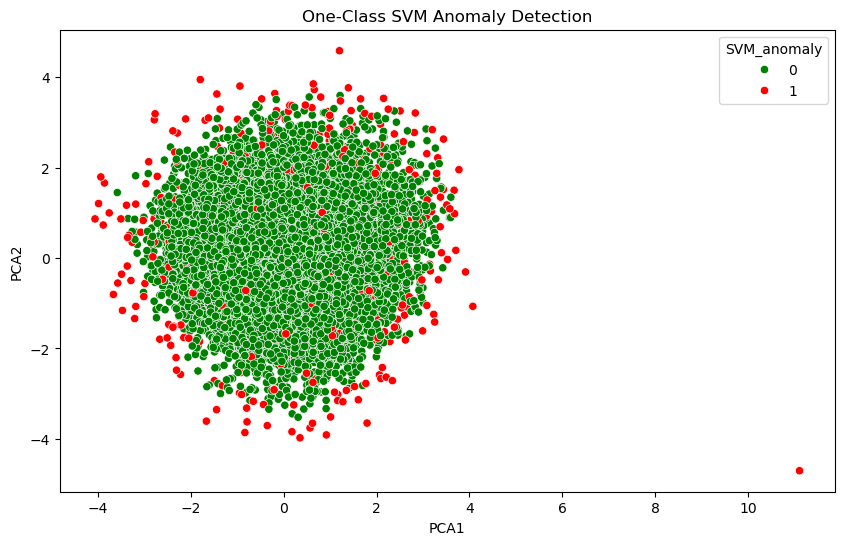

SVM Anomalies: 585


In [37]:
#Anomaly Detection Using One-Class SVM

# Train One-Class SVM
svm = OneClassSVM(kernel='rbf', nu=0.03, gamma='auto')
svm_pred = svm.fit_predict(X_scaled)
df['SVM_anomaly'] = (svm_pred == -1).astype(int)

# Visualise in 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='SVM_anomaly', palette=['green', 'red'])
plt.title("One-Class SVM Anomaly Detection")
plt.show()

# Count anomalies
print("SVM Anomalies:", df['SVM_anomaly'].sum())


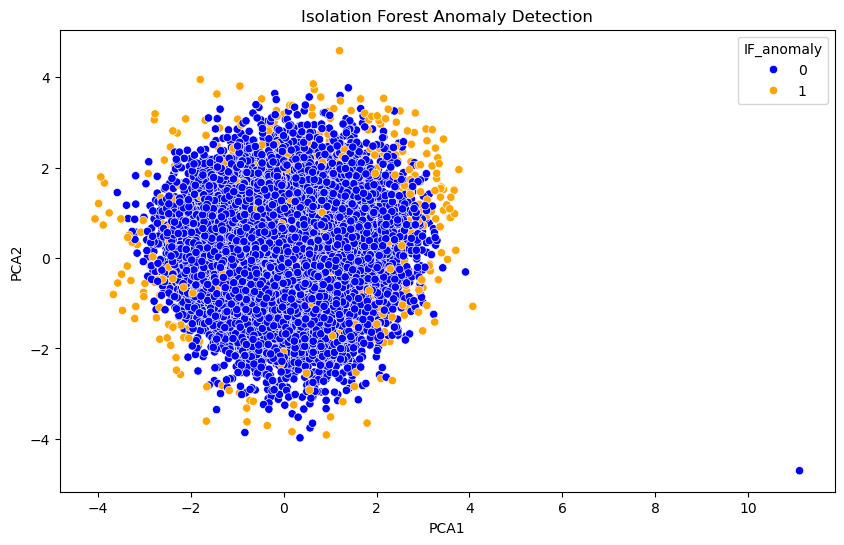

Isolation Forest Anomalies: 587


In [45]:
# Anomaly Detection Using Isolation Forest

# Train Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_pred = iso.fit_predict(X_scaled)
df['IF_anomaly'] = (iso_pred == -1).astype(int)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='IF_anomaly', palette=['blue', 'orange'])
plt.title("Isolation Forest Anomaly Detection")
plt.show()

# Count anomalies
print("Isolation Forest Anomalies:", df['IF_anomaly'].sum())